# Imports

In [ ]:
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=430b88210f8f37ccb398b4efe1cd32f4ade329e7171539fce46dbfb92726e338
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [ ]:
# general imports
import os
import cv2
import time
import numpy as np
import pandas as pd
from numpy.linalg import norm
import matplotlib.pyplot as plt

# read image
from PIL import Image, ImageOps

# metrics
from rouge_score import rouge_scorer
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error as mae

# vectorize styles
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# read data
from keras_preprocessing.image import ImageDataGenerator as IDG

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/UW/RecSys/Project/' 
images_loc = root +  'data/images/'
styles_loc = root +  'data/'

Mounted at /content/drive


# Read Text Data

In [ ]:
# read styles sheet
styles = pd.read_csv(styles_loc + 'styles.csv',  nrows=4000) # you can change the number here to subsample the data
styles['image'] = styles.apply(lambda row: str(row['id']) + '.jpg', axis=1)
styles = styles.drop(['Unnamed: 10', 'Unnamed: 11', 'year', 'productDisplayName'], axis=1)
print(styles.shape)
styles.head(5)

(4000, 9)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,Casual,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,Casual,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,Casual,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,Casual,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual,53759.jpg


In [ ]:
print(len(styles))
styles = styles.dropna()
print(len(styles))

4000
3961


# Find K Most Similar Function

In [ ]:
# find the k most similar items
def find_k_most_similar(v_in, v_in_idx, k, df, type_embed=""):
  # get name of input  vector
  v_image_name = df[df['id'] == df['id'][v_in_idx]]['image'].values[0]
  # create empty diictionary for image name and similarity to given input vector
  imageName_sim_dic = {}
  # loop the items
  for i in range(0,df.shape[0]):
    # get the name  of the image 
    image_name = df[df['id'] == df['id'][i]]['image'].values[0]
    # get the vector representation for the image
    v = df.iloc[i][2:]
    # get the cosine similarity for the orginal and current vec
    sim = np.dot(v_in,v)/(norm(v_in)*norm(v))
    #print(f'{image_name} - {sim}')
    # add them to dictionary
    imageName_sim_dic[image_name] = sim
  # sort the dictionary in descending and return the names of the sort 
  imageNames_sorted = sorted(imageName_sim_dic, key=imageName_sim_dic.__getitem__, reverse=True)[:k+1] # take top k of sorted list
  # remove the copy
  if v_image_name in imageNames_sorted: 
    imageNames_sorted.remove(v_image_name)
  else:
    imageNames_sorted = imageNames_sorted[:k]
  # plot the original and recommended items
  fig, ax = plt.subplots(nrows=1,ncols=6, figsize=(20,5))
  ax[0].set_title(f'Original Item - {v_image_name}')
  ax[0].imshow(Image.open(images_loc + v_image_name))
  for j in range(1,len(imageNames_sorted)+1):
    ax[j].set_title(f'Rec Item #{j} - {imageNames_sorted[j-1]}')
    ax[j].imshow(Image.open(images_loc + imageNames_sorted[j-1]))
  fig.suptitle(type_embed, fontweight='bold')
  plt.show()
  return imageNames_sorted

In [ ]:
# define metrics with SSIM
def get_score(og_image_name, rec_images_names):
  sum_score = 0
  scores = []
  og_im = np.array(ImageOps.grayscale(Image.open(images_loc + og_image_name)))
  #og_im = Image.open(images_loc + og_image_name)
  for rec in rec_images_names:
    rec_img = np.array(ImageOps.grayscale(Image.open(images_loc + rec)))
    #rec_img = Image.open(images_loc + rec)
    score = ssim(og_im, rec_img)
    scores.append(score)
    sum_score += score
  return sum_score/len(rec_images_names), scores

In [ ]:
# test metrics with cosine simi 
def get_score2(og_image_name, rec_images_names):
  sum_score = 0
  og_im = np.array(Image.open(images_loc + og_image_name)).flatten()
  #og_im = Image.open(images_loc + og_image_name)
  for rec in rec_images_names:
    rec_img = np.array(Image.open(images_loc + rec)).flatten()
    #rec_img = Image.open(images_loc + rec)
    score = np.dot(og_im, rec_img) / (norm(og_im)*norm(rec_img))
    sum_score += score
  return sum_score/len(rec_images_names)

# Baseline Image-Based

In [ ]:
moment_features = []
histo_features = []

def reset_df_vars():
  moment_features = []
  histo_features = []

def preprocess_(x):
  reset_df_vars()
  # create gray and hsv versions of input tensor
  img_gray = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
  img_hsv = cv2.cvtColor(x, cv2.COLOR_RGB2HSV)\
  # threshold the image for moments calculation
  _, img_thresh = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)
  hu_moments = cv2.HuMoments(cv2.moments(img_thresh))
  for i in range(0,7):
    hu_moments[i] = -1* np.copysign(1.0, hu_moments[i]) * np.log10(abs(hu_moments[i]))
  moment_features.append(hu_moments)

  hist = cv2.calcHist([img_hsv], [0,1,2], None, [7,7,7], [0,256,0,256,0,256])
  cv2.normalize(hist, hist)

  histo_features.append(hist.flatten())
  
  return x

In [ ]:
gen = IDG(
    rescale=1./255,
    preprocessing_function=preprocess_
)

images = gen.flow_from_dataframe (
    dataframe=styles,
    directory=images_loc,
    batch_size=32,
    x_col='image', 
    y_col='subCategory',
    target_size=(80,60),
    color_mode='rgb',
    shuffle=False,
    class_mode='categorical'
)

Found 3959 validated image filenames belonging to 35 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
# generate preprocessing feature table
counter = 0
for img, lbl in images:
  print(f'batch: {counter}')
  counter += 1
  if counter == int(np.ceil(styles.shape[0] / images.batch_size)):
    break

batch: 0
batch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100
batch: 101
batch:

In [ ]:
histo_df = pd.DataFrame(np.array(histo_features))
print(np.isinf(histo_df).values.sum())
print(histo_df.shape)

0
(3959, 343)


In [ ]:
moments_df = pd.DataFrame(np.squeeze(np.array(moment_features)), columns=['m0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6'])
print(np.isinf(moments_df).values.sum())
moments_df.replace(np.inf, 0, inplace=True)
print(np.isinf(moments_df).values.sum())
print(moments_df.shape)

360
0
(3959, 7)


In [ ]:
# subset the styles dataframe
image_embeddings_df = styles[['id', 'image']]
# reset the index of the dataframe
image_embeddings_df.reset_index(drop=True, inplace=True)
# concat the new embeddings df with the actual embeddings
image_embeddings_df = pd.concat([image_embeddings_df, histo_df, moments_df], axis=1)
print(image_embeddings_df.shape)
image_embeddings_df

(3961, 352)


,id,image,0,1,2,3,4,5,6,7,...,340,341,342,m0,m1,m2,m3,m4,m5,m6
0,15970,15970.jpg,0.000000,0.000473,0.001420,0.006388,0.030048,0.103157,0.994189,0.0,...,0.0,0.0,0.0,3.163990,7.436112,16.061078,14.779258,30.514496,18.516240,-30.257410
1,39386,39386.jpg,0.007815,0.038425,0.016933,0.014002,0.014328,0.037448,0.979505,0.0,...,0.0,0.0,0.0,2.988826,7.291531,13.390915,11.527599,23.999638,15.188677,24.608274
2,59263,59263.jpg,0.031808,0.009997,0.027719,0.036807,0.067706,0.083156,0.945160,0.0,...,0.0,0.0,0.0,3.011626,7.592098,12.160423,10.840575,-22.717945,14.899656,-22.383190
3,21379,21379.jpg,0.002606,0.004777,0.007382,0.031267,0.071218,0.132014,0.962750,0.0,...,0.0,0.0,0.0,3.121669,7.697696,12.250075,12.005740,-24.135044,15.905131,-25.230184
4,53759,53759.jpg,0.001629,0.004886,0.005972,0.015202,0.040176,0.063522,0.701456,0.0,...,0.0,0.0,0.0,2.925713,7.328506,11.927936,10.081263,21.197770,13.755460,21.283364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956,12191,12191.jpg,0.002128,0.005676,0.007804,0.017027,0.028378,0.040794,0.968769,0.0,...,0.0,0.0,0.0,3.024261,7.562136,12.229888,11.309412,-23.183125,15.144238,-23.288750
3957,55656,55656.jpg,0.002506,0.008076,0.004734,0.005013,0.020052,0.066003,0.995337,0.0,...,0.0,0.0,0.0,3.150840,7.513511,13.536644,12.892030,26.214474,16.669565,26.309635
3958,31313,31313.jpg,0.000000,0.000334,0.002674,0.004011,0.004011,0.009025,0.931570,0.0,...,0.0,0.0,0.0,2.942495,6.947593,11.131154,10.560822,21.406810,14.034861,-24.434484
3959,50324,50324.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


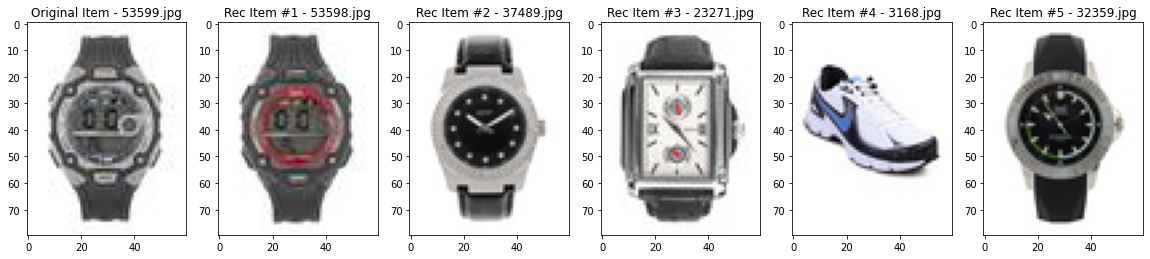

Average SSIM Score: (0.4711189441144736, [0.7713668937538017, 0.4685148803348536, 0.32915921650609015, 0.28472048247203385, 0.5018332475055882])


In [ ]:
idx = 3541
v_in = image_embeddings_df.iloc[idx][2:]
sorted_names = find_k_most_similar(v_in, idx, 5, image_embeddings_df)
v_in_name = image_embeddings_df[image_embeddings_df['id'] == image_embeddings_df['id'][idx]]['image'].values[0]
print(f'Average SSIM Score: {get_score(v_in_name, sorted_names)}')

# Baseline Text-Based

In [ ]:
text_array = styles[['gender',	'masterCategory',	'subCategory',	'articleType', 'baseColour',	'season',	'usage']].to_numpy()
text_array = np.array([' '.join(word) for word in text_array])

text_array

array(['Men Apparel Topwear Shirts Navy Blue Fall Casual',
       'Men Apparel Bottomwear Jeans Blue Summer Casual',
       'Women Accessories Watches Watches Silver Winter Casual', ...,
       'Women Apparel Topwear Kurtas Blue Summer Ethnic',
       'Women Apparel Topwear Kurtas Peach Summer Ethnic',
       'Women Accessories Bags Handbags Blue Summer Casual'], dtype='<U76')

In [ ]:
vectorizer = CountVectorizer(analyzer='word')
vec = vectorizer.fit_transform(text_array.ravel())
print(vectorizer.vocabulary_)

{'men': 106, 'apparel': 3, 'topwear': 180, 'shirts': 153, 'navy': 118, 'blue': 15, 'fall': 57, 'casual': 32, 'bottomwear': 19, 'jeans': 82, 'summer': 168, 'women': 199, 'accessories': 0, 'watches': 195, 'silver': 158, 'winter': 198, 'track': 181, 'pants': 127, 'black': 13, 'tshirts': 187, 'grey': 73, 'green': 72, 'ethnic': 49, 'purple': 137, 'socks': 162, 'footwear': 61, 'shoes': 155, 'belts': 12, 'flip': 59, 'flops': 60, 'bags': 7, 'handbags': 74, 'boys': 21, 'formal': 62, 'girls': 68, 'tops': 179, 'white': 197, 'innerwear': 79, 'bra': 22, 'beige': 11, 'brown': 26, 'sandal': 144, 'sandals': 145, 'unisex': 190, 'shoe': 154, 'sweatshirts': 172, 'sports': 163, 'personal': 132, 'care': 31, 'fragrance': 64, 'deodorant': 41, 'spring': 164, 'jewellery': 83, 'bracelet': 23, 'bronze': 25, 'lips': 97, 'lipstick': 98, 'flats': 58, 'kurtas': 88, 'teal': 176, 'copper': 39, 'pink': 133, 'off': 124, 'waistcoat': 192, 'shorts': 156, 'briefs': 24, 'maroon': 103, 'red': 138, 'saree': 146, 'sarees': 147

In [ ]:
# put dense vectors into dataframe
vec_df = pd.DataFrame(data=vec.toarray())
# subset the styles dataframe
text_embeddings_df = styles[['id', 'image']]
# reset the index of the dataframe
text_embeddings_df.reset_index(drop=True, inplace=True)
# concat the new embeddings df with the actual embeddings
text_embeddings_df = pd.concat([text_embeddings_df, vec_df], axis=1)
print(text_embeddings_df.shape)
text_embeddings_df.head()

(3961, 203)


,id,image,0,1,2,3,4,5,6,7,...,191,192,193,194,195,196,197,198,199,200
0,15970,15970.jpg,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39386,39386.jpg,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,59263,59263.jpg,1,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,1,1,0
3,21379,21379.jpg,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,53759,53759.jpg,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


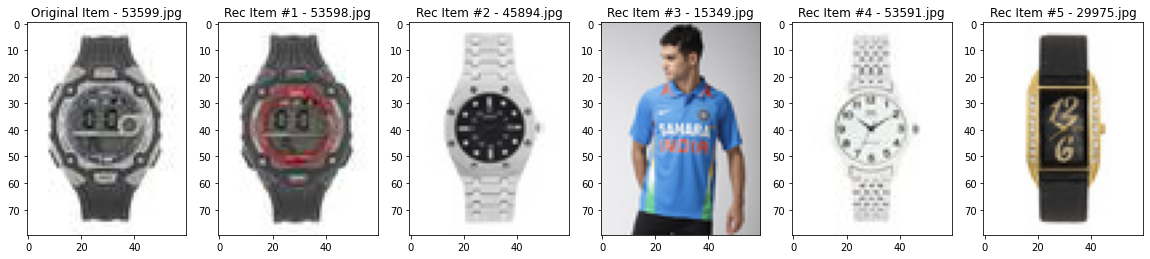

Average SSIM Score: (0.42190561833002993, [0.7713668937538017, 0.374151549660132, 0.21283639664964035, 0.325027895486168, 0.4261453561004079])


In [ ]:
idx = 3541
v_in = text_embeddings_df.iloc[idx][2:]
sorted_names = find_k_most_similar(v_in, idx, 5, text_embeddings_df)
v_in_name = text_embeddings_df[text_embeddings_df['id'] == text_embeddings_df['id'][idx]]['image'].values[0]
print(f'Average SSIM Score: {get_score(v_in_name, sorted_names)}')

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

orig_meta = vectorizer.inverse_transform(v_in.values.reshape(1, -1))[0]
print(f'Original Metadata: {orig_meta}\n')
for i, n in enumerate(sorted_names): 
  v_n = text_embeddings_df[text_embeddings_df['image'] == n].values[0][2:]
  sent = vectorizer.inverse_transform(v_n.reshape(1, -1))[0]
  scores = scorer.score(' '.join(orig_meta), ' '.join(sent))
  print(f'Recommended # {i+1} Metadata: {sent} with ROUGE Score: {scores["rouge1"].fmeasure}')


Original Metadata: ['black' 'free' 'gifts' 'items' 'men' 'sports' 'winter']

Recommended # 1 Metadata: ['black' 'free' 'gifts' 'items' 'men' 'sports' 'winter'] with ROUGE Score: 1.0
Recommended # 2 Metadata: ['black' 'casual' 'free' 'gifts' 'items' 'men' 'winter'] with ROUGE Score: 0.8571428571428571
Recommended # 3 Metadata: ['blue' 'free' 'gifts' 'items' 'men' 'sports' 'winter'] with ROUGE Score: 0.8571428571428571
Recommended # 4 Metadata: ['casual' 'free' 'gifts' 'items' 'men' 'white' 'winter'] with ROUGE Score: 0.7142857142857143
Recommended # 5 Metadata: ['black' 'casual' 'free' 'gifts' 'items' 'winter' 'women'] with ROUGE Score: 0.7142857142857143


# Combine Text and Image Based

In [ ]:
image_embeddings_df.head()

,id,image,0,1,2,3,4,5,6,7,...,340,341,342,m0,m1,m2,m3,m4,m5,m6
0,15970,15970.jpg,0.007558,0.010797,0.013497,0.021595,0.037791,0.086919,0.905905,0.0,...,0.0,0.0,0.0,3.036466,7.515981,12.066342,11.438795,-23.227103,15.201905,-23.600793
1,39386,39386.jpg,0.000000,0.001250,0.001250,0.014164,0.042075,0.048324,0.942313,0.0,...,0.0,0.0,0.0,2.970819,7.295196,12.483209,11.694752,23.917962,15.376603,-23.951853
2,59263,59263.jpg,0.000000,0.000473,0.001420,0.006388,0.030048,0.103157,0.994189,0.0,...,0.0,0.0,0.0,3.163990,7.436112,16.061078,14.779258,30.514496,18.516240,-30.257410
3,21379,21379.jpg,0.007815,0.038425,0.016933,0.014002,0.014328,0.037448,0.979505,0.0,...,0.0,0.0,0.0,2.988826,7.291531,13.390915,11.527599,23.999638,15.188677,24.608274
4,53759,53759.jpg,0.031808,0.009997,0.027719,0.036807,0.067706,0.083156,0.945160,0.0,...,0.0,0.0,0.0,3.011626,7.592098,12.160423,10.840575,-22.717945,14.899656,-22.383190


In [ ]:
text = text_embeddings_df.copy()
_ = text.pop('image')
_ = text.pop('id')
test_df = pd.concat([image_embeddings_df, text], axis=1)

In [ ]:
test_df.head()

,id,image,0,1,2,3,4,5,6,7,...,191,192,193,194,195,196,197,198,199,200
0,15970,15970.jpg,0.007558,0.010797,0.013497,0.021595,0.037791,0.086919,0.905905,0.0,...,0,0,0,0,0,0,0,0,0,0
1,39386,39386.jpg,0.000000,0.001250,0.001250,0.014164,0.042075,0.048324,0.942313,0.0,...,0,0,0,0,0,0,0,0,0,0
2,59263,59263.jpg,0.000000,0.000473,0.001420,0.006388,0.030048,0.103157,0.994189,0.0,...,0,0,0,0,2,0,0,1,1,0
3,21379,21379.jpg,0.007815,0.038425,0.016933,0.014002,0.014328,0.037448,0.979505,0.0,...,0,0,0,0,0,0,0,0,0,0
4,53759,53759.jpg,0.031808,0.009997,0.027719,0.036807,0.067706,0.083156,0.945160,0.0,...,0,0,0,0,0,0,0,0,0,0


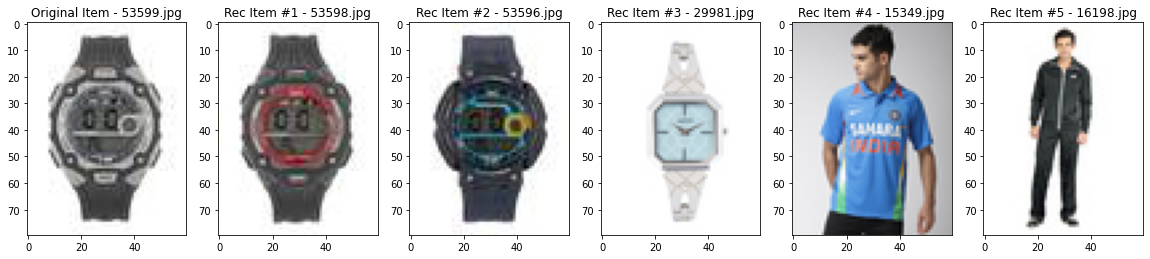

In [ ]:
idx = 3541
v_in = test_df.iloc[idx][2:]
sorted_names = find_k_most_similar(v_in, idx, 5, test_df)

# Run Full Test

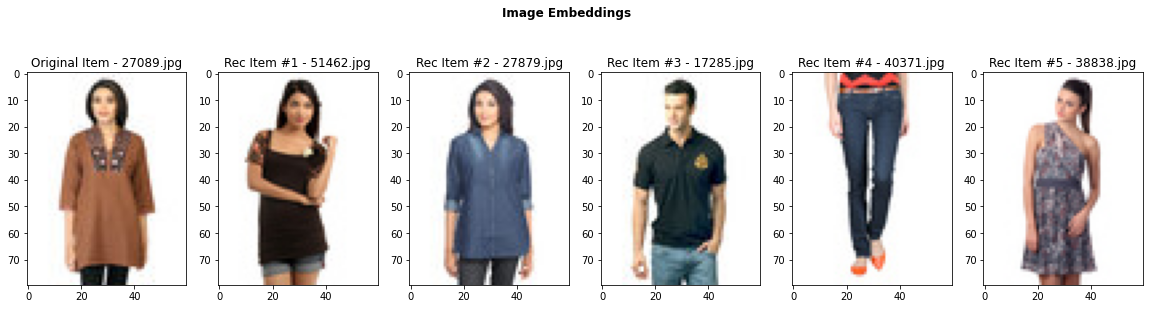

Individual Scores: [0.45120688497137884, 0.666520525080017, 0.5022710295840623, 0.3262501117453414, 0.4486230704053501]
Average SSIM Score: 0.47897432435722986


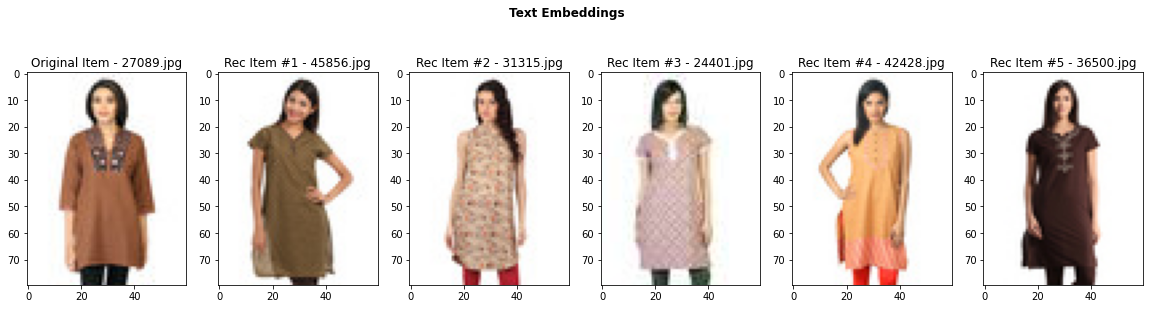

Individual Scores: [0.5035678693177759, 0.5066100658488741, 0.4205582002833743, 0.49664247559130476, 0.4895792622034243]
Average SSIM Score: 0.48339157464895066


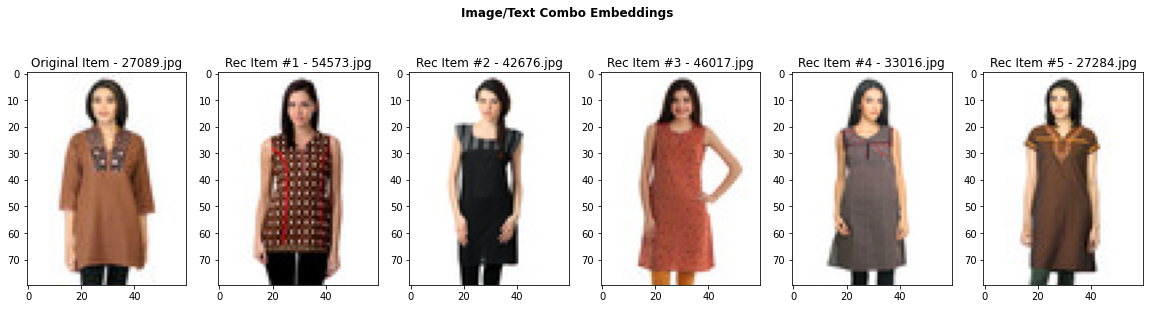

Individual Scores: [0.5512820073824739, 0.4703082940760746, 0.4800342243997772, 0.5202586764899236, 0.5716061085788127]
Average SSIM Score: 0.5186978621854125


In [ ]:
idx = 467

# test image embedding recommendations
v_in = image_embeddings_df.iloc[idx][2:]
sorted_names = find_k_most_similar(v_in, idx, 5, image_embeddings_df, 'Image Embeddings')
v_in_name = image_embeddings_df[image_embeddings_df['id'] == image_embeddings_df['id'][idx]]['image'].values[0]
avg_score, scores = get_score(v_in_name, sorted_names)
print(f'Individual Scores: {scores}')
print(f'Average SSIM Score: {avg_score}')

# test text based embedding recommendations
v_in = text_embeddings_df.iloc[idx][2:]
sorted_names  = find_k_most_similar(v_in, idx, 5, text_embeddings_df, 'Text Embeddings')
v_in_name = text_embeddings_df[text_embeddings_df['id'] == text_embeddings_df['id'][idx]]['image'].values[0]
avg_score, scores = get_score(v_in_name, sorted_names)
print(f'Individual Scores: {scores}')
print(f'Average SSIM Score: {avg_score}')

# test combo based embedding recommendations
v_in = test_df.iloc[idx][2:]
sorted_names  = find_k_most_similar(v_in, idx, 5, test_df, 'Image/Text Combo Embeddings')
v_in_name = test_df[test_df['id'] == test_df['id'][idx]]['image'].values[0]
avg_score, scores = get_score(v_in_name, sorted_names)
print(f'Individual Scores: {scores}')
print(f'Average SSIM Score: {avg_score}')